***Import all the Dependencies***

In [ ]:
from google.colab import drive
drive.mount("/content/drive/")
import tensorflow as tf
import os
import glob 
import skimage
import random 
import pandas as pd
import numpy as np
import seaborn as sns
import keras
from keras.layers import Dense, Conv2D , MaxPooling2D, Activation , Flatten , Dropout , BatchNormalization
from sklearn.metrics import classification_report,confusion_matrix
import math
import cv2
from PIL import Image
import numpy as np
from keras import layers
from keras.callbacks import Callback, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from keras.models import Model
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, accuracy_score
import scipy
from tqdm import tqdm
from keras import backend as K
import cv2 as cv
import gc
from functools import partial
from sklearn import metrics
from collections import Counter
import json
from tensorflow.keras.applications import EfficientNetB7
import itertools
import matplotlib.pyplot as plt  
%matplotlib inline
from skimage import io as io

Mounted at /content/drive/


***Prepare training and validation dataset***


In [ ]:
def Dataset_loader(DIR, RESIZE, sigmaX=10):
    IMG = []
    read = lambda imname: np.asarray(Image.open(imname).convert("RGB"))
    for IMAGE_NAME in tqdm(os.listdir(DIR)):
        PATH = os.path.join(DIR,IMAGE_NAME)
        _, ftype = os.path.splitext(PATH)
        img = read(PATH)
        IMG.append(np.array(img))
    return IMG

disease_train = np.array(Dataset_loader('/content/drive/MyDrive/Plant Diseases Dataset /train/Disease',512))
healthy_train =np.array(Dataset_loader('/content/drive/MyDrive/Plant Diseases Dataset /train/Healthy',512))
disease_test =np.array(Dataset_loader('/content/drive/MyDrive/Plant Diseases Dataset /valid/Disease',512))
healthy_test = np.array(Dataset_loader('/content/drive/MyDrive/Plant Diseases Dataset /valid/Healthy',512))

100%|██████████| 350/350 [00:02<00:00, 134.06it/s]


In [ ]:
disease_train_label = np.zeros(len(disease_train))
healthy_train_label = np.ones(len(healthy_train))
disease_test_label = np.zeros(len(disease_test))
healthy_test_label = np.ones(len(healthy_test))

# Merge data 
X_train = np.concatenate((disease_train, healthy_train), axis = 0)
Y_train = np.concatenate((disease_train_label, healthy_train_label), axis = 0)
X_test = np.concatenate((disease_test, healthy_test), axis = 0)
Y_test = np.concatenate((disease_test_label, healthy_test_label), axis = 0)

# Shuffle train data
s = np.arange(X_train.shape[0])
np.random.shuffle(s)
X_train = X_train[s]
Y_train = Y_train[s]

# Shuffle test data
s = np.arange(X_test.shape[0])
np.random.shuffle(s)
X_test = X_test[s]
Y_test = Y_test[s]

# To categorical
Y_train = to_categorical(Y_train, num_classes= 2)
Y_test = to_categorical(Y_test, num_classes= 2)

print(X_train.shape)
print(Y_train.shape)

print(X_test.shape)
print(Y_test.shape)

(3600, 256, 256, 3)
(3600, 2)
(700, 256, 256, 3)
(700, 2)


In [ ]:
x_train = X_train
y_train =Y_train
x_test = X_test
y_test =Y_test

x_train, x_test, y_train, y_test = train_test_split(
   X_train, Y_train, 
  test_size=0.2, 
   random_state=12,
)

print(x_train.shape)
print(y_train.shape)

print(x_test.shape)
print(y_test.shape)


(2880, 256, 256, 3)
(2880, 2)
(720, 256, 256, 3)
(720, 2)


***Build the model***

In [ ]:
model = Sequential()
model.add(Conv2D(16,(5,5),padding='valid',input_shape=(256, 256, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=2,padding = 'valid'))
model.add(Dropout(0.4))
model.add(Conv2D(64,(5,5),padding='valid'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=2,padding = 'valid'))
model.add(Dropout(0.6))
model.add(Conv2D(64,(5,5),padding='valid'))
model.add(Activation('relu'))
model.add(Dropout(0.8))
model.add(Flatten())
model.add(Dense(256, name="dense_1"))
model.add(Activation('softmax'))
model_feat = Model(inputs=model.input,outputs=model.get_layer('dense_1').output)
feat_train = model_feat.predict(x_train)#Extracted Features from CNN
feat_test = model_feat.predict(x_test)
# print(feat_test)

print(feat_train)

[[  0.40216637 -24.92806      8.676306   ...  -9.96622    -21.558
  -34.39467   ]
 [-19.326998   -12.60448      4.1043453  ... -30.61448    -15.528209
  -25.39751   ]
 [-21.926157   -17.134163     6.1166134  ... -27.87807    -14.029714
  -34.986515  ]
 ...
 [ -1.368866   -10.2809725  -10.387369   ... -13.43346     -3.2108376
  -14.942813  ]
 [-22.112972    -7.232934    -1.2162857  ... -26.600626    -7.0191374
  -26.273317  ]
 [-39.64982    -10.682472     5.327839   ... -27.195545   -31.672207
  -40.999798  ]]


***Gaussian Radial Basis Function (RBF) kernel for SVM***

In [ ]:
from sklearn.svm import SVC
svclassifier = SVC()
svclassifier = SVC(kernel='rbf', random_state=42,C=1.0, degree=3, 
          gamma='scale', coef0=0.0, shrinking=True, probability=False, tol=0.001, cache_size=200, class_weight=None, verbose=False,
          max_iter=-1, decision_function_shape='ovr', break_ties=False)
svclassifier.fit(feat_train,np.argmax(y_train,axis=1))
y_pred = svclassifier.predict(feat_test)

from sklearn.metrics import accuracy_score
print('Accuracy: %.3f' % accuracy_score(np.argmax(y_test,axis=1), y_pred))
from sklearn.metrics import precision_score
print('Precision: %.3f' % precision_score(np.argmax(y_test,axis=1), y_pred))
from sklearn.metrics import recall_score
print('Recall: %.3f' % recall_score(np.argmax(y_test,axis=1), y_pred))
from sklearn.metrics import f1_score
print('F1 Score: %.3f' % f1_score(np.argmax(y_test,axis=1), y_pred))

Accuracy: 0.892
Precision: 0.922
Recall: 0.861
F1 Score: 0.890


***Naive Bayes Classifier***




In [ ]:
from sklearn.naive_bayes import GaussianNB
model = GaussianNB(priors=None, var_smoothing=1e-09)
model.fit(feat_train,np.argmax(y_train,axis=1))
y_pred=model.predict(feat_test)
from sklearn.metrics import accuracy_score
print('Accuracy: %.3f' % accuracy_score(np.argmax(y_test,axis=1), y_pred))
from sklearn.metrics import precision_score
print('Precision: %.3f' % precision_score(np.argmax(y_test,axis=1), y_pred,))
from sklearn.metrics import recall_score
print('Recall: %.3f' % recall_score(np.argmax(y_test,axis=1), y_pred))
from sklearn.metrics import f1_score
print('F1 Score: %.3f' % f1_score(np.argmax(y_test,axis=1), y_pred))

Accuracy: 0.747
Precision: 0.794
Recall: 0.682
F1 Score: 0.734


***CNN model - Efficientnetb7 model ***

In [ ]:
def build_model(num_classes):
    base_model = EfficientNetB7(input_shape = (256, 256, 3),  weights='imagenet',include_top = False,)
    for layer in base_model.layers:
        layer.trainable = False
    x = base_model.output
    x = Flatten()(x)
    x = Dense(256, activation="relu")(x)
    x = Dropout(0.5)(x)
    predictions = Dense(2, activation="softmax")(x)

    model = tf.keras.Model( base_model.input,predictions)
    model.compile(
        optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"]
    )
    return model

K.clear_session()
gc.collect()

model = build_model(num_classes=2)
model.summary()

258088960/258076736 [==============================] - 2s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 256, 256, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 256, 256, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 stem_conv_pad (ZeroPadding

***Data Augumentation***

In [ ]:
BATCH_SIZE = 20
train_generator = ImageDataGenerator(
        zoom_range=2,  # set range for random zoom
        rotation_range = 90,
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True,  # randomly flip images
    )

In [ ]:
# Learning Rate Reducer
learn_control = ReduceLROnPlateau(monitor='val_accuracy', patience=5,
                                  verbose=1,factor=0.2, min_lr=1e-7)

# Checkpoint
filepath="/content/drive/MyDrive/efficientmodel.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True,save_weights_only=False, mode='max')

***Training and Evaluation***

In [11]:
history = model.fit(
    train_generator.flow(x_train, y_train,batch_size=BATCH_SIZE),
    steps_per_epoch=x_train.shape[0] / BATCH_SIZE,
    epochs=25,
    validation_data=train_generator.flow(x_test, y_test, batch_size=BATCH_SIZE),
    callbacks=[learn_control, checkpoint]
)

Epoch 1/25
144/144 [==============================] - ETA: 0s - loss: 6.2219 - accuracy: 0.7899
Epoch 1: val_accuracy improved from -inf to 0.89167, saving model to /content/drive/MyDrive/efficientmodel.h5
144/144 [==============================] - 336s 2s/step - loss: 6.2219 - accuracy: 0.7899 - val_loss: 0.3540 - val_accuracy: 0.8917 - lr: 0.0010
Epoch 2/25
144/144 [==============================] - ETA: 0s - loss: 0.3912 - accuracy: 0.8743
Epoch 2: val_accuracy improved from 0.89167 to 0.94167, saving model to /content/drive/MyDrive/efficientmodel.h5
144/144 [==============================] - 407s 3s/step - loss: 0.3912 - accuracy: 0.8743 - val_loss: 0.1910 - val_accuracy: 0.9417 - lr: 0.0010
Epoch 3/25
144/144 [==============================] - ETA: 0s - loss: 0.3918 - accuracy: 0.8795
Epoch 3: val_accuracy did not improve from 0.94167
144/144 [==============================] - 367s 3s/step - loss: 0.3918 - accuracy: 0.8795 - val_loss: 0.2088 - val_accuracy: 0.9194 - lr: 0.0010
Epo

***Plotting the Graph ***

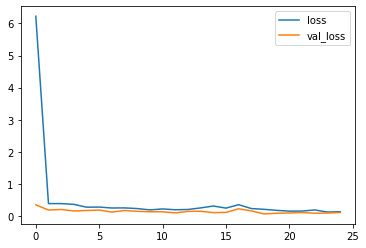

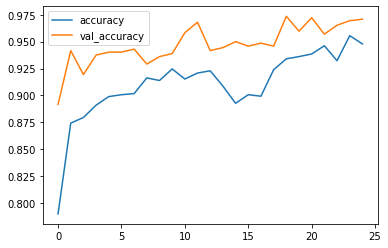

In [23]:
history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot()

history_df = pd.DataFrame(history.history)
history_df[['accuracy', 'val_accuracy']].plot()

In [24]:
#We have to the change the name of the file everytime we train the model.
history_df.to_csv('/content/drive/MyDrive/efficientNetpro.csv', mode='a',header=False, index = False)

In [25]:
history_df

,loss,accuracy,val_loss,val_accuracy,lr
0,6.221909,0.789931,0.354006,0.891667,0.00100
1,0.391201,0.874306,0.191006,0.941667,0.00100
2,0.391775,0.879514,0.208813,0.919444,0.00100
3,0.367801,0.890972,0.161820,0.937500,0.00100
4,0.280424,0.898958,0.176597,0.940278,0.00100
5,0.283458,0.900694,0.189964,0.940278,0.00100
6,0.254686,0.901736,0.127942,0.943056,0.00100
7,0.257819,0.916319,0.176800,0.929167,0.00100
8,0.236939,0.913889,0.150635,0.936111,0.00100
9,0.195628,0.924653,0.137657,0.938889,0.00100


In [26]:
history_df = history_df.apply(pd.to_numeric)

***Prediction***

In [27]:
Y_test_pred = model.predict(x_test)

In [28]:
Y_pred = model.predict(X_test)

In [29]:
print("The Accuracy of EfficientNet B7 is :",round(accuracy_score(np.argmax(y_test, axis=1), np.argmax(Y_test_pred, axis=1))*100,2))

The Accuracy of EfficientNet B7 is : 99.03


In [30]:
tta_steps = 5
predictions = []

for i in tqdm(range(tta_steps)):
    preds = model.predict_generator(train_generator.flow(x_test, batch_size=BATCH_SIZE, shuffle=False),
                                    steps = len(x_test)/BATCH_SIZE)
    
    predictions.append(preds)
    gc.collect()
    
Y_pred_tta = np.mean(predictions, axis=0)

  0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  
100%|██████████| 5/5 [06:10<00:00, 74.14s/it]


In [31]:
from sklearn.metrics import classification_report
classification_report( np.argmax(y_test, axis=1), np.argmax(Y_pred_tta, axis=1))

'              precision    recall  f1-score   support\n\n           0       1.00      0.99      0.99       352\n           1       0.99      1.00      0.99       368\n\n    accuracy                           0.99       720\n   macro avg       0.99      0.99      0.99       720\nweighted avg       0.99      0.99      0.99       720\n'

***Confusion Matrix***

Confusion matrix, without normalization
[[347   5]
 [  2 366]]


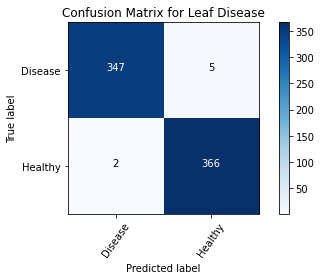

In [32]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=55)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

cm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(Y_test_pred, axis=1))

cm_plot_label =['Disease', 'Healthy']
plot_confusion_matrix(cm, cm_plot_label, title ='Confusion Matrix for Leaf Disease')

***Predicted Image Plot***

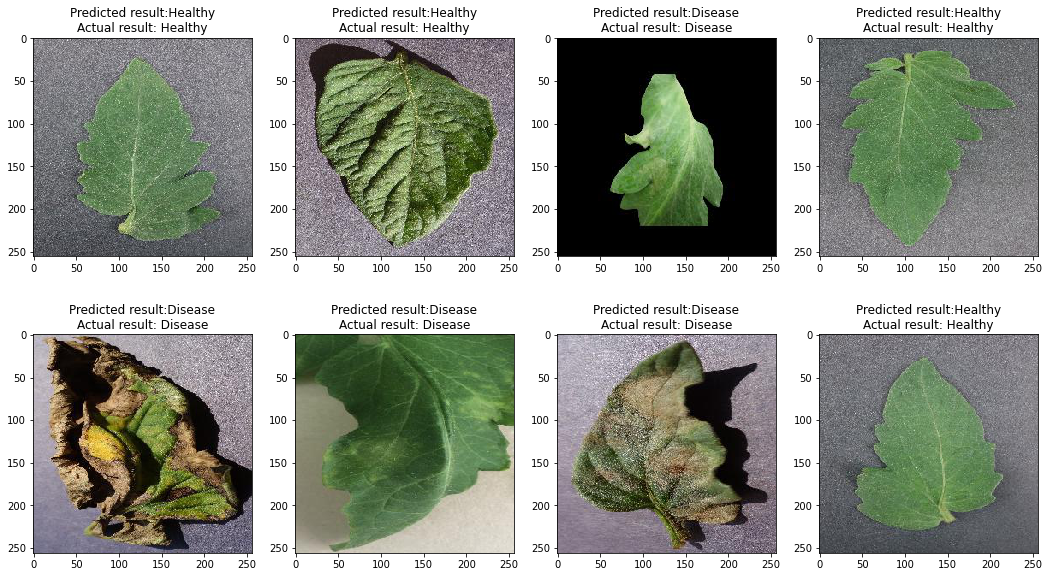

In [33]:
i=0
prop_class=[]
mis_class=[]

for i in range(len(Y_test)):
    if(np.argmax(Y_test[i])==np.argmax(Y_pred_tta[i])):
        prop_class.append(i)
    if(len(prop_class)==8):
        break

i=0
for i in range(len(Y_test)):
    if(not np.argmax(Y_test[i])==np.argmax(Y_pred_tta[i])):
        mis_class.append(i)
    if(len(mis_class)==8):
        break

# # Display first 8 images of Leafs
w=60
h=40
fig=plt.figure(figsize=(18, 10))
columns = 4
rows = 2

def Transfername(namecode):
    if namecode==0:
        return "Disease"     
    else:
        return "Healthy"
    
for i in range(len(prop_class)):
    ax = fig.add_subplot(rows, columns, i+1)
    ax.set_title("Predicted result:"+ Transfername(np.argmax(Y_pred_tta[prop_class[i]]))
                       +"\n"+"Actual result: "+ Transfername(np.argmax(Y_test[prop_class[i]])))
    plt.imshow(X_test[prop_class[i]], interpolation='nearest')
plt.show()